<span style="color:black">Question  1A:

In [3]:
import pandas as pd
from scipy.stats import skew, kurtosis


df = pd.read_csv("problem1.csv")
data = df["X"]
mean = data.mean()
variance = data.var()
skewness = skew(data)
kurt = kurtosis(data)
print(f"Mean: {mean}")
print(f"Variance: {variance}")
print(f"Skewness: {skewness}")
print(f"Kurtosis: {kurt}")

Mean: 0.05019795790476916
Variance: 0.010332476407479588
Skewness: 0.1204447119194402
Kurtosis: 0.2229270674503816


<span style="color:black">Question 1B:

<span style="font-size:15px;color:black">It depends on whether the distribution has a big population. If the sample size is bigger than 30, I will choose normal distribution, and if the sample size is smaller than 30, I will choose T-distribution. It also depends on whether I know the population standard deviation. If it is known, there is high chance that I choose normal distribution. Still, if the data is known to be skewed or has extreme outliers, I would choose T-distribution over normal distribution since a dataset with more symmetricity percularities is more fit for normal distribution. Normal distribution would be forced to be used somehow under the condition that normality is assumed like linear regression. Under this situation, there is a slight skewness, so I decide to choose T-distribution. 

<span style="color:black">Question 1C:

In [4]:
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import kstest


df_t, loc, scale = t.fit(data)
print(f"T Distribution Fit: df = {df_t}, loc = {loc}, scale = {scale}")
mu, sigma = norm.fit(data)
print(f"Normal Distribution Fit: Mean = {mu}, Std = {sigma}")

ks_normal = kstest(data, 'norm', args=(mu, sigma))
ks_t = kstest(data, 't', args=(df_t, loc, scale))
print(f"Normal K-S Test: {ks_normal}")
print(f"T Distribution K-S Test: {ks_t}")

T Distribution Fit: df = 28.71016692613074, loc = 0.04986675416872735, scale = 0.09800128766123102
Normal Distribution Fit: Mean = 0.05019795790476916, Std = 0.10159795239606018
Normal K-S Test: KstestResult(statistic=np.float64(0.01275165971875869), pvalue=np.float64(0.9962422791034079), statistic_location=np.float64(0.1931202657983203), statistic_sign=np.int8(1))
T Distribution K-S Test: KstestResult(statistic=np.float64(0.012697894723120384), pvalue=np.float64(0.996453485092733), statistic_location=np.float64(-0.0377745593740776), statistic_sign=np.int8(1))


<span style="font-size:15px;color:black">Based on the test result provided above, both T-distribution and normal distribution has high p-values with 0.99624 for Normal distribution and 0.99645 for T-distribution. For practical application, both could be implemented with confidence. T-distribution has a slightly lower statistic data then normal distribution, so T-distribution is actually a little bit better than normal distribution under this dataset. Therefore, my choice matches with data. 

<span style="color:black">Question 2A: 

In [2]:
import pandas as pd

file_path = 'problem2.csv' 
data2 = pd.read_csv(file_path)

cov_matrix = data2.cov()

print("Pairwise Covariance Matrix:")
print(cov_matrix)

Pairwise Covariance Matrix:
          x1        x2        x3        x4        x5
x1  1.470484  1.454214  0.877269  1.903226  1.444361
x2  1.454214  1.252078  0.539548  1.621918  1.237877
x3  0.877269  0.539548  1.272425  1.171959  1.091912
x4  1.903226  1.621918  1.171959  1.814469  1.589729
x5  1.444361  1.237877  1.091912  1.589729  1.396186


<span style="color:black">Question 2B: 

In [22]:
import numpy as np

def is_positive_semi_definite(matrix):
    eigenvalues = np.linalg.eigvals(matrix)
    return np.all(eigenvalues >= 0), eigenvalues


is_psd, eigenvalues = is_positive_semi_definite(cov_matrix)

print("Positive semi-definite?", is_psd)
print("Eigenvalues:", eigenvalues)

Positive semi-definite? False
Eigenvalues: [ 6.78670573  0.83443367 -0.31024286  0.02797828 -0.13323183]


This matrix is not PSD because some of its eigenvalues are negative. 

<span style="color:black">Question 2C: 

In [8]:
import pandas as pd
import numpy as np


variances_vector = np.diag(cov_matrix)
standard_deviations = np.sqrt(variances_vector)


diag_std_matrix = np.diag(standard_deviations)
inv_diag_std_matrix = np.diag(1.0 / standard_deviations)
initial_correlation_matrix = inv_diag_std_matrix @ cov_matrix @ inv_diag_std_matrix


def project_onto_PSD(matrix):
    eigenvalues, eigenvectors = np.linalg.eigh(matrix)
    eigenvalues = np.maximum(eigenvalues, 0)
    return eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T

def project_onto_unit_diagonal(matrix):
    modified_matrix = matrix.copy()
    np.fill_diagonal(modified_matrix, 1.0)
    return modified_matrix

def compute_matrix_infinity_norm(matrix):
    return np.max(np.sum(np.abs(matrix), axis=1))

def higham_nearest_correlation(matrix, max_iterations=100, tolerance=1e-8):
    previous_Y = matrix.copy()
    previous_X = matrix.copy()
    delta_S = np.zeros_like(matrix)
    
    for _ in range(max_iterations):
        residual_matrix = previous_Y - delta_S
        X_psd = project_onto_PSD(residual_matrix)
        delta_S = X_psd - residual_matrix
        Y_unit_diag = project_onto_unit_diagonal(X_psd)
        

        delta_X = compute_matrix_infinity_norm(X_psd - previous_X) / compute_matrix_infinity_norm(X_psd)
        delta_Y = compute_matrix_infinity_norm(Y_unit_diag - previous_Y) / compute_matrix_infinity_norm(Y_unit_diag)
        delta_XY = compute_matrix_infinity_norm(Y_unit_diag - X_psd) / compute_matrix_infinity_norm(Y_unit_diag)
        
        max_delta = max(delta_X, delta_Y, delta_XY)
        
        if max_delta <= tolerance:
            break
            
        previous_X, previous_Y = X_psd.copy(), Y_unit_diag.copy()
        
    return X_psd


nearest_correlation_psd = higham_nearest_correlation(initial_correlation_matrix)
nearest_covariance_psd = diag_std_matrix @ nearest_correlation_psd @ diag_std_matrix


higham_psd = pd.DataFrame(nearest_covariance_psd)
print(f'Nearest PSD Covariance Matrix:\n{higham_psd}')

Nearest PSD Covariance Matrix:
          0         1         2         3         4
0  1.470484  1.332361  0.884378  1.627602  1.399556
1  1.332361  1.252078  0.619028  1.450604  1.214450
2  0.884378  0.619028  1.272425  1.076847  1.059658
3  1.627602  1.450604  1.076847  1.814469  1.577928
4  1.399556  1.214450  1.059658  1.577928  1.396186


<span style="color:black">Question 2D: 

In [19]:
def nearPSD(A, epsilon=0):
    A = (A + A.T) / 2
    eigval, eigvec = np.linalg.eigh(A)
    eigval = np.maximum(eigval, epsilon)
    reconstructed_matrix = eigvec @ np.diag(eigval) @ eigvec.T
    
    if np.allclose(np.diag(A), 1):  
        D = np.diag(1 / np.sqrt(np.diag(reconstructed_matrix)))
        reconstructed_matrix = D @ reconstructed_matrix @ D
    
    return reconstructed_matrix


variances = np.diag(cov_matrix)
std_devs = np.sqrt(variances)

D = np.diag(std_devs)
D_inv = np.diag(1.0 / std_devs)

corr_matrix = D_inv @ cov_matrix @ D_inv

e = nearPSD(corr_matrix)
nearest_cov_psd = D @ e @ D


nearest_cov_psd_df = pd.DataFrame(nearest_cov_psd)
print("Nearest Positive Semi-Definite Matrix (Rebonato and Jackel):")
print(nearest_cov_psd_df)

Nearest Positive Semi-Definite Matrix (Rebonato and Jackel):
          0         1         2         3         4
0  1.470484  1.327009  0.842583  1.624464  1.364833
1  1.327009  1.252078  0.555421  1.433109  1.165906
2  0.842583  0.555421  1.272425  1.052789  1.060424
3  1.624464  1.433109  1.052789  1.814469  1.544993
4  1.364833  1.165906  1.060424  1.544993  1.396186


<span style="color:black">Question 2E: 

In [18]:
print("Difference between Higham's PSD and Overlapping Data Covariance Matrix:")
print(nearest_covariance_psd - cov_matrix)

print("Difference between Rebonato and Jackel's PSD and Overlapping Data Covariance Matrix:")
print(nearest_cov_psd - cov_matrix)

Difference between Higham's PSD and Overlapping Data Covariance Matrix:
              x1            x2            x3            x4            x5
x1  3.912592e-08 -1.218535e-01  7.108576e-03 -2.756246e-01 -4.480541e-02
x2 -1.218535e-01  1.916824e-08  7.947982e-02 -1.713142e-01 -2.342662e-02
x3  7.108576e-03  7.947982e-02  3.488501e-09 -9.511247e-02 -3.225366e-02
x4 -2.756246e-01 -1.713142e-01 -9.511247e-02  5.778196e-08 -1.180031e-02
x5 -4.480541e-02 -2.342662e-02 -3.225366e-02 -1.180031e-02  3.811949e-08
Difference between Rebonato and Jackel's PSD and Overlapping Data Covariance Matrix:
              x1            x2            x3            x4            x5
x1  2.220446e-16 -1.272051e-01 -3.468565e-02 -2.787626e-01 -7.952841e-02
x2 -1.272051e-01  2.220446e-16  1.587256e-02 -1.888090e-01 -7.197070e-02
x3 -3.468565e-02  1.587256e-02 -2.220446e-16 -1.191699e-01 -3.148783e-02
x4 -2.787626e-01 -1.888090e-01 -1.191699e-01  2.220446e-16 -4.473607e-02
x5 -7.952841e-02 -7.197070e-02 -3.148783

Higham's method and Rebonato and Jackel's method both adjust the original covariance matrix to ensure it is positive semi-definite. The overlapping data covariance matrix is calculated using only complete cases, which may result in a different matrix due to the exclusion of incomplete rows. The differences between the adjusted matrices and the overlapping data matrix highlight how the methods handle missing data and enforce positive semi-definiteness.

Question 3A: 

In [49]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal


def estimate_parameters(data):
    mu = data.mean().values
    cov_matrix = data.cov().values
    return mu, cov_matrix


def conditional_distribution(mu, cov_matrix, x1_given):
    sigma1_sq = cov_matrix[0, 0]
    sigma2_sq = cov_matrix[1, 1]
    sigma12 = cov_matrix[0, 1]
    
    rho = sigma12 / np.sqrt(sigma1_sq * sigma2_sq)
    mu_2_given_1 = mu[1] + rho * np.sqrt(sigma2_sq / sigma1_sq) * (x1_given - mu[0])
    sigma2_given_1_sq = sigma2_sq * (1 - rho ** 2)
    
    return mu_2_given_1, sigma2_given_1_sq


data3 = pd.read_csv('problem3.csv')
mu, cov_matrix = estimate_parameters(data3)


print("Mean vector:")
print(mu)
print("\nCovariance matrix:")
print(cov_matrix)

Mean vector:
[0.04600157 0.09991502]

Covariance matrix:
[[0.0101622  0.00492354]
 [0.00492354 0.02028441]]


Question 3B: 

Conditional Mean: 0.3683249958609775
Conditional Variance: 0.01789896964508752


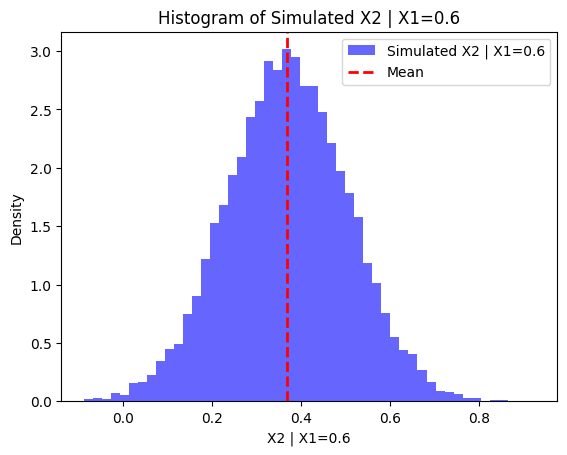

In [51]:
import matplotlib.pyplot as plt


def conditional_distribution(mu, cov_matrix, x1_given):
    sigma1_sq = cov_matrix[0, 0]
    sigma2_sq = cov_matrix[1, 1]
    sigma12 = cov_matrix[0, 1]
    
    rho = sigma12 / np.sqrt(sigma1_sq * sigma2_sq)
    mu_2_given_1 = mu[1] + rho * np.sqrt(sigma2_sq / sigma1_sq) * (x1_given - mu[0])
    sigma2_given_1_sq = sigma2_sq * (1 - rho ** 2)
    
    return mu_2_given_1, sigma2_given_1_sq


def simulate_conditional_distribution(mu_2_given_1, sigma2_given_1_sq, num_samples=10000):
    return np.random.normal(mu_2_given_1, np.sqrt(sigma2_given_1_sq), num_samples)
    

def plot_histogram(data, mu_2_given_1, title):
    plt.hist(data, bins=50, density=True, alpha=0.6, color='b', label="Simulated X2 | X1=0.6")
    plt.axvline(mu_2_given_1, color='r', linestyle='dashed', linewidth=2, label="Mean")
    plt.xlabel("X2 | X1=0.6")
    plt.ylabel("Density")
    plt.title(title)
    plt.legend()
    plt.show()

    
x1_given = 0.6
mu_2_given_1, sigma2_given_1_sq = conditional_distribution(mu, cov_matrix, x1_given)
print(f"Conditional Mean: {mu_2_given_1}")
print(f"Conditional Variance: {sigma2_given_1_sq}")
simulated_x2 = simulate_conditional_distribution(mu_2_given_1, sigma2_given_1_sq)
plot_histogram(simulated_x2, mu_2_given_1, "Histogram of Simulated X2 | X1=0.6")

Question 3C: 

In [54]:
L = np.linalg.cholesky(cov_matrix)
L11 = L[0, 0]
L21 = L[1, 0]
L22 = L[1, 1]


mu_2_given_1_cholesky = mu[1] + (L21 / L11) * (x1_given - mu[0])
sigma_2_given_1_cholesky = L22
print(f"Conditional Mean using cholesky root: {mu_2_given_1_cholesky}")
print(f"Conditional Variance using cholesky root: {sigma_2_given_1_cholesky**2}")

Conditional Mean using cholesky root: 0.3683249958609775
Conditional Variance using cholesky root: 0.017898969645087522


Question  4A:  

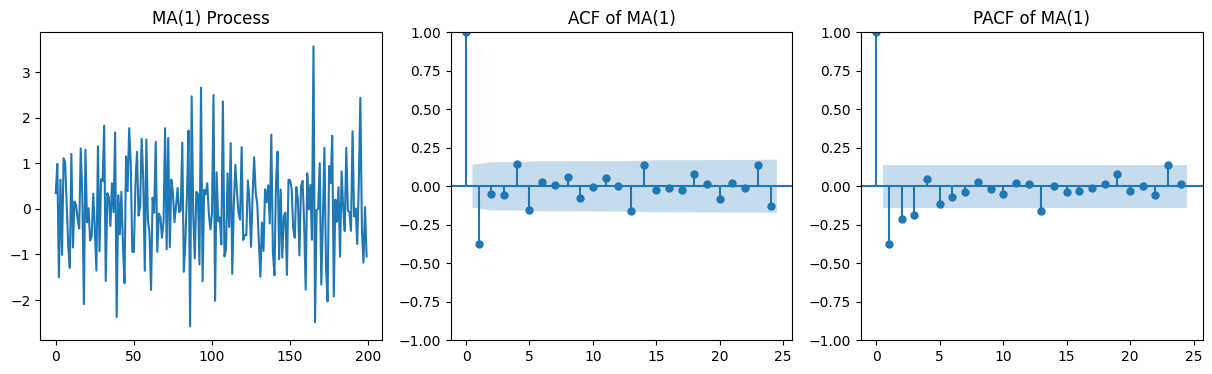

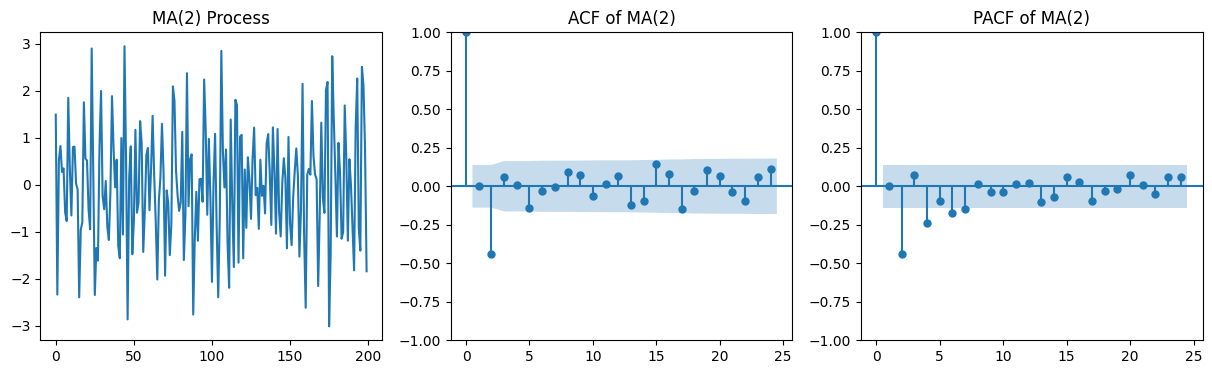

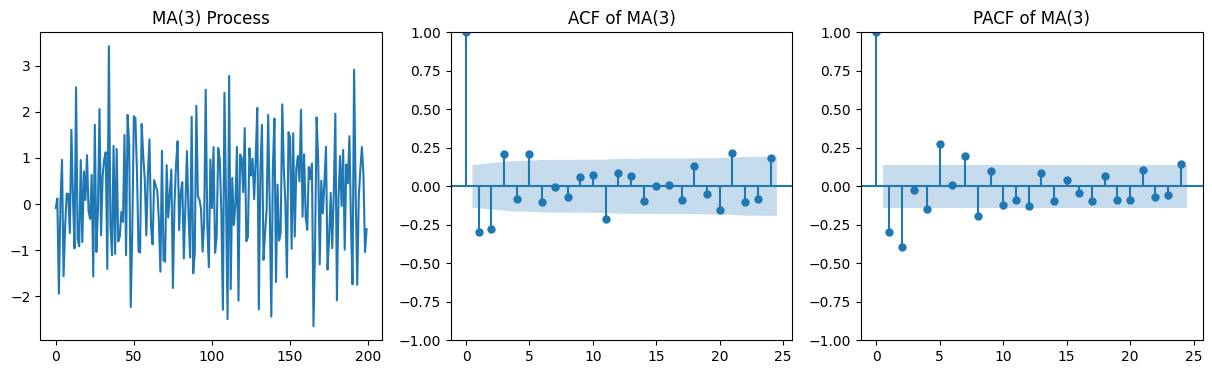

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import acf, pacf

file_path = "problem4.csv"
data = pd.read_csv(file_path)

def simulate_ma(q):
    ma_params = np.r_[1, np.random.uniform(-0.8, 0.8, q)] 
    ma_process = ArmaProcess(ma=[1] + list(-ma_params[1:]), ar=[1])
    simulated_data = ma_process.generate_sample(nsample=200)

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    axes[0].plot(simulated_data)
    axes[0].set_title(f'MA({q}) Process')

    sm.graphics.tsa.plot_acf(simulated_data, ax=axes[1])
    axes[1].set_title(f'ACF of MA({q})')

    sm.graphics.tsa.plot_pacf(simulated_data, ax=axes[2])
    axes[2].set_title(f'PACF of MA({q})')

    plt.show()

for q in [1, 2, 3]:
    simulate_ma(q)

Question 4B: 

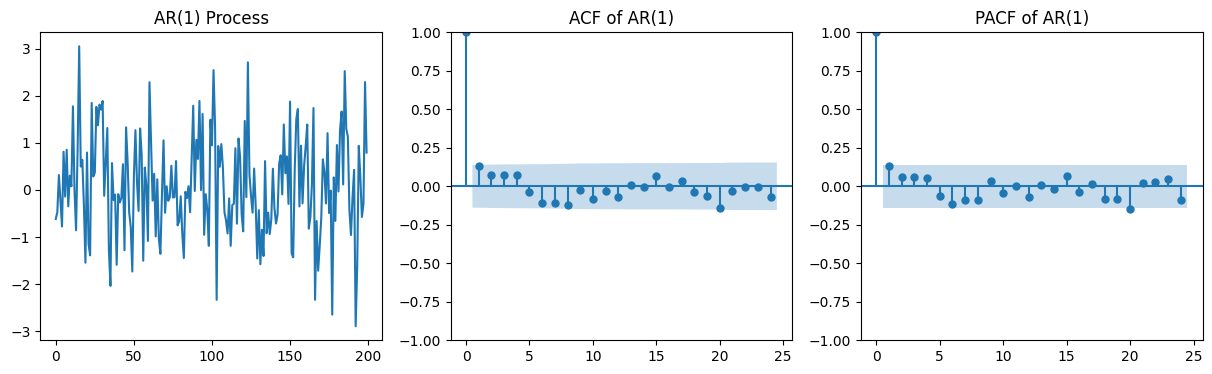

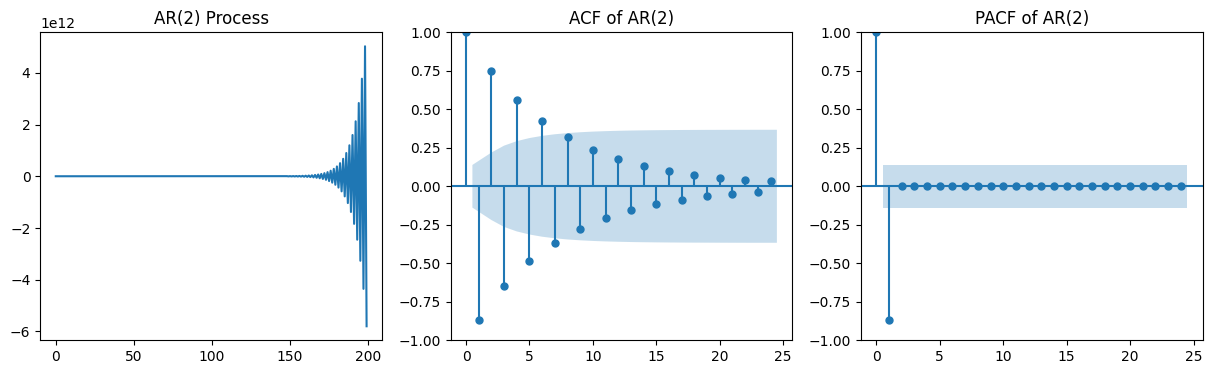

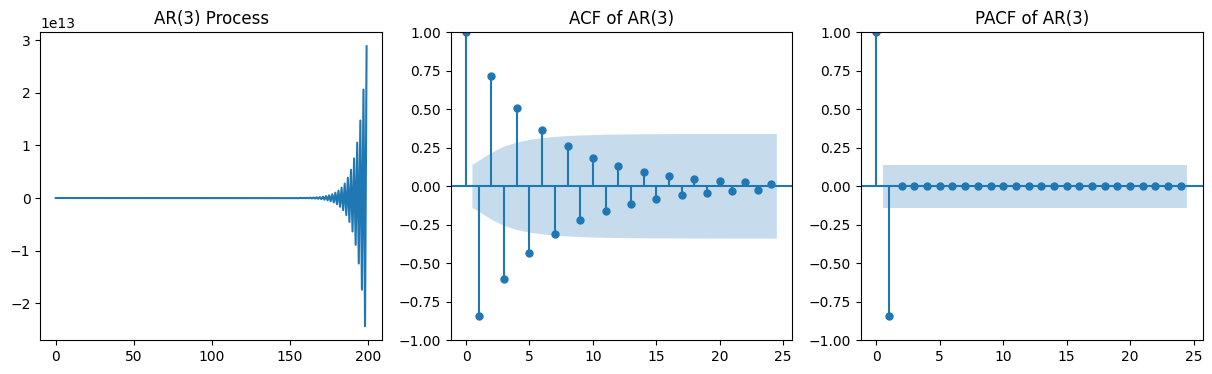

In [23]:
def simulate_ar(p):
    ar_params = np.r_[1, np.random.uniform(-0.8, 0.8, p)] 
    ar_process = ArmaProcess(ar=[1] + list(-ar_params[1:]), ma=[1])
    simulated_data = ar_process.generate_sample(nsample=200)

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    axes[0].plot(simulated_data)
    axes[0].set_title(f'AR({p}) Process')

    sm.graphics.tsa.plot_acf(simulated_data, ax=axes[1])
    axes[1].set_title(f'ACF of AR({p})')

    sm.graphics.tsa.plot_pacf(simulated_data, ax=axes[2])
    axes[2].set_title(f'PACF of AR({p})')

    plt.show()

for p in [1, 2, 3]:
    
    simulate_ar(p)


Question 4C: 

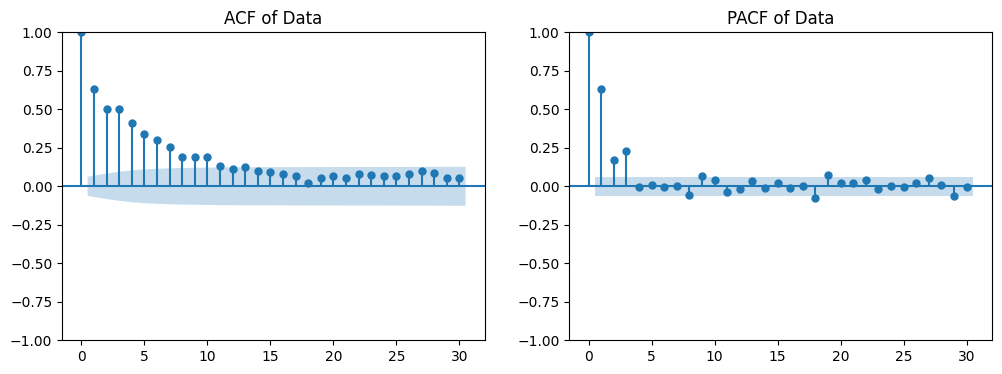

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sm.graphics.tsa.plot_acf(data["y"], ax=axes[0])
axes[0].set_title("ACF of Data")

sm.graphics.tsa.plot_pacf(data["y"], ax=axes[1])
axes[1].set_title("PACF of Data")

plt.show()

Question 4D: 

In [28]:
from statsmodels.tsa.arima.model import ARIMA

def compute_aicc(model):
    aic = model.aic
    n = len(data["y"])
    k = model.params.shape[0]  # Number of parameters
    aicc = aic + (2 * k * (k + 1)) / (n - k - 1)
    return aicc

models = {"AR(1)": (1, 0, 0), "AR(2)": (2, 0, 0), "AR(3)": (3, 0, 0),
          "MA(1)": (0, 0, 1), "MA(2)": (0, 0, 2), "MA(3)": (0, 0, 3),
          "ARMA(1,1)": (1, 0, 1), "ARMA(2,2)": (2, 0, 2)}

aicc_values = {}
for name, order in models.items():
    model = ARIMA(data["y"], order=order).fit()
    aicc_values[name] = compute_aicc(model)

aicc_df = pd.DataFrame.from_dict(aicc_values, orient="index", columns=["AICc"])
aicc_df = aicc_df.sort_values(by="AICc")

print(aicc_df)


/home/whz22715/fintech/guide/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                  AICc
AR(3)     -1746.221359
ARMA(2,2) -1739.961771
ARMA(1,1) -1723.414338
AR(2)     -1696.051484
AR(1)     -1669.065171
MA(3)     -1645.072607
MA(2)     -1559.210731
MA(1)     -1508.902937


The AR(3) model has the lowest AICc value, therefore it is considered as the best-fitting model.

Question 5A: 

In [60]:
import numpy as np
import pandas as pd


file_path = "DailyReturn.csv"
returns_data = pd.read_csv(file_path, index_col=0)
lambda_ewma = 0.97


def exponentially_weighted_covariance(returns, lambda_ewma):
    mean_returns = returns.mean()
    centered_returns = returns - mean_returns
    n = len(returns)


    weights = np.array([(1 - lambda_ewma) * lambda_ewma ** (n - i - 1) for i in range(n)])
    weights /= weights.sum() 
    ewma_cov_matrix = np.dot(centered_returns.T, np.diag(weights) @ centered_returns)
    return pd.DataFrame(ewma_cov_matrix, index=returns.columns, columns=returns.columns)
cov_matrix = exponentially_weighted_covariance(returns_data, lambda_ewma)


print("Custom Exponentially Weighted Covariance Matrix:")
print(cov_matrix)

Custom Exponentially Weighted Covariance Matrix:
           SPY      AAPL      NVDA      MSFT      AMZN      META     GOOGL  \
SPY   0.000072  0.000054  0.000126  0.000081  0.000112  0.000082  0.000087   
AAPL  0.000054  0.000140  0.000042  0.000085  0.000080  0.000058  0.000070   
NVDA  0.000126  0.000042  0.000670  0.000137  0.000195  0.000192  0.000143   
MSFT  0.000081  0.000085  0.000137  0.000163  0.000173  0.000129  0.000121   
AMZN  0.000112  0.000080  0.000195  0.000173  0.000323  0.000187  0.000201   
...        ...       ...       ...       ...       ...       ...       ...   
KKR   0.000135  0.000042  0.000223  0.000107  0.000188  0.000121  0.000160   
MU    0.000150  0.000057  0.000314  0.000157  0.000171  0.000172  0.000164   
PLD   0.000060  0.000061  0.000019  0.000064  0.000056  0.000018  0.000024   
LRCX  0.000128  0.000085  0.000326  0.000155  0.000185  0.000232  0.000157   
EQIX  0.000052  0.000038  0.000048  0.000053  0.000071  0.000073  0.000052   

          AVGO

Question 5B: 

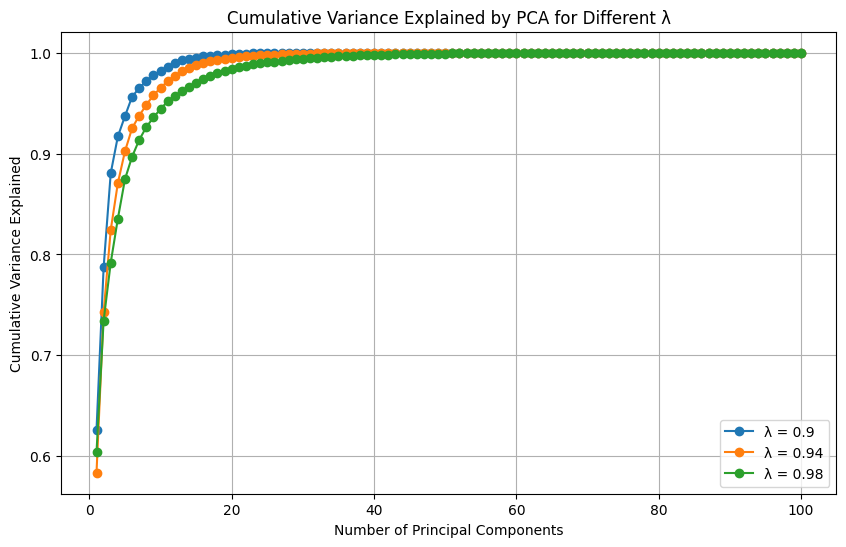

In [36]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


lambda_values = [0.90, 0.94, 0.98]
pca_results = {}
for lambd in lambda_values:
    cov_matrix = exp_weighted_cov(returns, lambd)
    pca = PCA()
    pca.fit(cov_matrix)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    pca_results[lambd] = cumulative_variance


plt.figure(figsize=(10, 6))
for lambd, variance in pca_results.items():
    plt.plot(range(1, len(variance) + 1), variance, marker='o', label=f'λ = {lambd}')

plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Variance Explained")
plt.title("Cumulative Variance Explained by PCA for Different λ")
plt.legend()
plt.grid(True)
plt.show()

Question 6A: 

In [16]:
import numpy as np
import pandas as pd

 
file_path = "problem6.csv"
cov_matrix = pd.read_csv(file_path).values
eigvals, eigvecs = np.linalg.eigh(cov_matrix)
eigvals[eigvals < 1e-10] = 1e-10  
cov_matrix = eigvecs @ np.diag(eigvals) @ eigvecs.T

In [18]:
def simulate_cholesky(cov_matrix, num_samples=10000):
    mean = np.zeros(cov_matrix.shape[0]) 
    L = np.linalg.cholesky(cov_matrix)  
    normal_samples = np.random.randn(num_samples, cov_matrix.shape[0])  
    simulated_data = normal_samples @ L.T + mean 
    return simulated_data


cholesky_samples = simulate_cholesky(cov_matrix)
cholesky_samples

array([[ 0.02464765,  0.01341339, -0.06122328, ..., -0.00631423,
         0.06605532, -0.01128102],
       [ 0.04882884, -0.00254869, -0.19021477, ...,  0.06444756,
        -0.08967682, -0.03447831],
       [-0.00947799,  0.04683591,  0.04600485, ..., -0.01871241,
         0.05463355, -0.00637846],
       ...,
       [ 0.13632819,  0.09056861,  0.12741194, ...,  0.01472782,
         0.05380821, -0.01537088],
       [-0.05673   ,  0.07764705, -0.00241691, ...,  0.0385179 ,
        -0.0564049 ,  0.03037687],
       [-0.0620353 , -0.01610188,  0.01582894, ..., -0.03120206,
        -0.06445731, -0.00907022]], shape=(10000, 500))

Question 6B: 

In [14]:
from sklearn.decomposition import PCA


def simulate_pca(cov_matrix, num_samples=10000, variance_explained=0.75):
    mean = np.zeros(cov_matrix.shape[0])  
    eig_vals, eig_vecs = np.linalg.eigh(cov_matrix)  
    eig_vals_sorted = np.argsort(eig_vals)[::-1]  
    eig_vals, eig_vecs = eig_vals[eig_vals_sorted], eig_vecs[:, eig_vals_sorted]

    
    cum_variance = np.cumsum(eig_vals) / np.sum(eig_vals)
    num_components = np.searchsorted(cum_variance, variance_explained) + 1 


    principal_components = eig_vecs[:, :num_components] @ np.diag(np.sqrt(eig_vals[:num_components]))
    normal_samples = np.random.randn(num_samples, num_components)  
    simulated_data = normal_samples @ principal_components.T + mean 

    return simulated_data


pca_samples = simulate_pca(cov_matrix)
pca_samples

array([[-0.07822732, -0.01730933,  0.09423997, ..., -0.03314283,
        -0.06381464, -0.00738605],
       [-0.03952515,  0.02214645,  0.00033831, ..., -0.03010386,
        -0.03894093, -0.019427  ],
       [ 0.03887545, -0.03156254, -0.06018864, ..., -0.04160354,
         0.01359354, -0.02003226],
       ...,
       [ 0.04992693,  0.0468795 , -0.10683638, ...,  0.02123458,
        -0.0446919 ,  0.02878406],
       [ 0.01389595,  0.04613957, -0.02456072, ..., -0.06535114,
         0.10971484, -0.00832799],
       [ 0.01325988, -0.03711993, -0.16008547, ..., -0.00071074,
        -0.02847226, -0.02107303]], shape=(10000, 500))

Question 6C: 

In [19]:
cholesky_cov = np.cov(cholesky_samples, rowvar=False)
pca_cov = np.cov(pca_samples, rowvar=False)


frobenius_cholesky = np.linalg.norm(cholesky_cov - cov_matrix, 'fro')
frobenius_pca = np.linalg.norm(pca_cov - cov_matrix, 'fro')


print(f"Frobenius norm (Cholesky): {frobenius_cholesky}")
print(f"Frobenius norm (PCA): {frobenius_pca}")

Frobenius norm (Cholesky): 0.02081853912491849
Frobenius norm (PCA): 0.08309815998717068


Question 6D: 

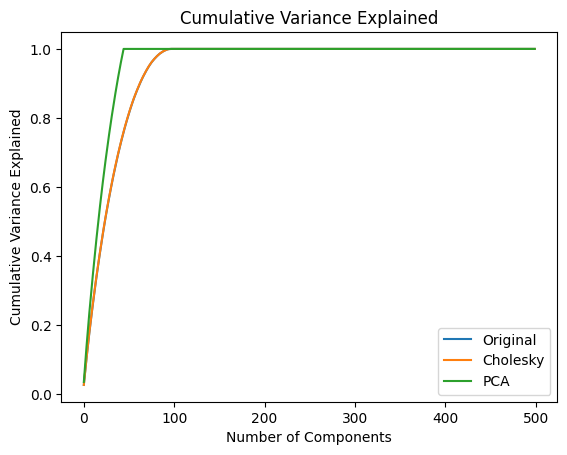

In [21]:
orig_eig_vals, _ = np.linalg.eigh(cov_matrix)
orig_eig_vals = np.sort(orig_eig_vals)[::-1]


cholesky_eig_vals, _ = np.linalg.eigh(cholesky_cov)
cholesky_eig_vals = np.sort(cholesky_eig_vals)[::-1]


pca_eig_vals, _ = np.linalg.eigh(pca_cov)
pca_eig_vals = np.sort(pca_eig_vals)[::-1]


orig_cum_var = np.cumsum(orig_eig_vals) / np.sum(orig_eig_vals)
cholesky_cum_var = np.cumsum(cholesky_eig_vals) / np.sum(cholesky_eig_vals)
pca_cum_var = np.cumsum(pca_eig_vals) / np.sum(pca_eig_vals)


import matplotlib.pyplot as plt


plt.plot(orig_cum_var, label="Original")
plt.plot(cholesky_cum_var, label="Cholesky")
plt.plot(pca_cum_var, label="PCA")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Explained")
plt.legend()
plt.title("Cumulative Variance Explained")
plt.show()


Question 6E: 

In [23]:
import time


start_time = time.time()
simulate_cholesky(cov_matrix)
cholesky_time = time.time() - start_time


start_time = time.time()
simulate_pca(cov_matrix)
pca_time = time.time() - start_time


print(f"Cholesky Simulation Time: {cholesky_time:.5f} seconds")
print(f"PCA Simulation Time: {pca_time:.5f} seconds")

Cholesky Simulation Time: 0.14172 seconds
PCA Simulation Time: 0.03571 seconds
